# Noise plots for each image


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from utils.images_generator import salt_and_pepper_noise, salt_and_pepper_noise_v2, normalize_img_to_0_255, generate_histogram, colored_noise, uniform_image
from utils.experiments_functions import get_img_info
from itertools import combinations
from skimage import data
from skimage.color import rgb2gray

## Scikit images

Loading curves

In [2]:
skimage_data_sp = pd.read_csv(f"results/noise_analysis/sp/sp_analysis_skimage_noisegen.csv")
skimage_data_speckle = pd.read_csv(f"results/noise_analysis/speckle/speckle_analysis_skimage_noisegen.csv")
skimage_data_gaussian = pd.read_csv(f"results/noise_analysis/gaussian/gaussian_analysis_skimage_noisegen.csv")
skimage_data_poisson = pd.read_csv(f"results/noise_analysis/poisson/poisson_analysis_skimage_noisegen_normalized.csv")

print("Salt and Pepper Noise Analysis")
display(skimage_data_sp.head())
print("Speckle Noise Analysis")
display(skimage_data_speckle.head())
print("Gaussian Noise Analysis")
display(skimage_data_gaussian.head())
print("Poisson Noise Analysis")
display(skimage_data_poisson.head())

Salt and Pepper Noise Analysis


,q,Smoothness,Curve structure,Weighted Entropy Correct,Weighted Complexity Correct,prob0,prob1,prob2,image_name,noise_prob
0,0,0.226687,0.149256,0.942420,0.066415,0.560020,0.294618,0.145362,data.astronaut,0.00
1,0,0.147333,0.134769,0.966048,0.039202,0.480666,0.327051,0.192283,data.astronaut,0.05
2,0,0.090401,0.117398,0.977151,0.026448,0.423735,0.346832,0.229434,data.astronaut,0.10
3,0,0.057826,0.091624,0.978424,0.025129,0.391160,0.350232,0.258608,data.astronaut,0.15
4,0,0.036354,0.071836,0.972915,0.032548,0.369687,0.351075,0.279238,data.astronaut,0.20


Speckle Noise Analysis


,q,Smoothness,Curve structure,Weighted Entropy Correct,Weighted Complexity Correct,prob0,prob1,prob2,image_name,noise_mean,noise_sigma
0,0,0.226687,0.149256,0.942420,0.066415,0.560020,0.294618,0.145362,data.astronaut,0,0.00
1,0,0.143541,0.089763,0.967932,0.035205,0.476875,0.306444,0.216681,data.astronaut,0,0.05
2,0,0.118618,0.066364,0.972583,0.029337,0.451951,0.307206,0.240842,data.astronaut,0,0.10
3,0,0.104425,0.054783,0.974420,0.027034,0.437759,0.308512,0.253729,data.astronaut,0,0.15
4,0,0.097004,0.044259,0.975335,0.025890,0.430337,0.306961,0.262702,data.astronaut,0,0.20


Gaussian Noise Analysis


,q,Smoothness,Curve structure,Weighted Entropy Correct,Weighted Complexity Correct,prob0,prob1,prob2,image_name,mean_value,sd_value
0,0,0.226687,0.149256,0.942420,0.066415,0.560020,0.294618,0.145362,data.astronaut,0,0.00
1,0,0.030004,0.049341,0.998623,0.001812,0.363337,0.343002,0.293661,data.astronaut,0,0.05
2,0,0.014751,0.024713,0.999660,0.000447,0.348084,0.338314,0.313602,data.astronaut,0,0.10
3,0,0.008520,0.015020,0.999858,0.000187,0.341853,0.336583,0.321564,data.astronaut,0,0.15
4,0,0.006318,0.012044,0.999920,0.000105,0.339651,0.336197,0.324152,data.astronaut,0,0.20


Poisson Noise Analysis


,q,Smoothness,Curve structure,Weighted Entropy Correct,Weighted Complexity Correct,prob0,prob1,prob2,image_name,noise_factor
0,0,0.226687,0.149256,0.942420,0.066415,0.560020,0.294618,0.145362,data.astronaut,0.00
1,0,0.177204,0.116900,0.959459,0.045795,0.510537,0.303181,0.186281,data.astronaut,0.05
2,0,0.162927,0.106521,0.963080,0.041216,0.496260,0.305131,0.198609,data.astronaut,0.10
3,0,0.146241,0.095741,0.966373,0.036877,0.479575,0.308083,0.212342,data.astronaut,0.20
4,0,0.137111,0.086856,0.967625,0.035043,0.470445,0.308206,0.221349,data.astronaut,0.30


In [3]:
# Create new datasets for each image name by combining data from all noise types
''''
For each of the datasets loaded i need to group for each image_name. for each image_name, i need to have the smoothness,
curve structure, entropy and complexity. and for each dataset, a new attribute called param that is going to be the noise_prob (sp),
noise_sigma (speckle and gaussian) and noise_factor (poisson). So, generate a new dataset for each image_name with
the attributes: noise_type, param, smoothness, curve structure, entropy and complexity.
That way i will have the a dataset with noise information for each image used
'''
# First, let's process each noise dataset to have consistent column names
def process_dataset(df, noise_type, param_column):
    # Select and rename columns
    processed_df = df[['image_name', param_column, 'Smoothness', 'Curve structure', 
                      'Weighted Entropy Correct', 'Weighted Complexity Correct']].copy()
    
    # Rename the parameter column
    processed_df.rename(columns={param_column: 'param'}, inplace=True)
    
    # Add noise type column
    processed_df['noise_type'] = noise_type
    
    return processed_df

# Process each dataset
sp_processed = process_dataset(skimage_data_sp, 'salt_and_pepper', 'noise_prob')
speckle_processed = process_dataset(skimage_data_speckle, 'speckle', 'noise_sigma')
gaussian_processed = process_dataset(skimage_data_gaussian, 'gaussian', 'sd_value')
poisson_processed = process_dataset(skimage_data_poisson, 'poisson', 'noise_factor')

# Combine all datasets
combined_data = pd.concat([sp_processed, speckle_processed, gaussian_processed, poisson_processed])

# Get unique image names
image_names = combined_data['image_name'].unique()

# Create a dictionary to store dataframes for each image
image_dataframes = {}

# Create separate dataframe for each image
for image_name in image_names:
    image_dataframes[image_name] = combined_data[combined_data['image_name'] == image_name].copy()
    
# Display first few rows of each image dataframe
for image_name, df in image_dataframes.items():
    print(f"Dataset for {image_name}:")
    display(df.head())
    print("\n")

Dataset for data.astronaut:


,image_name,param,Smoothness,Curve structure,Weighted Entropy Correct,Weighted Complexity Correct,noise_type
0,data.astronaut,0.00,0.226687,0.149256,0.942420,0.066415,salt_and_pepper
1,data.astronaut,0.05,0.147333,0.134769,0.966048,0.039202,salt_and_pepper
2,data.astronaut,0.10,0.090401,0.117398,0.977151,0.026448,salt_and_pepper
3,data.astronaut,0.15,0.057826,0.091624,0.978424,0.025129,salt_and_pepper
4,data.astronaut,0.20,0.036354,0.071836,0.972915,0.032548,salt_and_pepper




Dataset for data.cat:


,image_name,param,Smoothness,Curve structure,Weighted Entropy Correct,Weighted Complexity Correct,noise_type
11,data.cat,0.00,0.270992,0.182980,0.931924,0.085099,salt_and_pepper
12,data.cat,0.05,0.161070,0.167462,0.968999,0.039735,salt_and_pepper
13,data.cat,0.10,0.090353,0.147120,0.983435,0.021350,salt_and_pepper
14,data.cat,0.15,0.044519,0.114545,0.987403,0.016198,salt_and_pepper
15,data.cat,0.20,0.024489,0.084705,0.983000,0.022000,salt_and_pepper




Dataset for data.coins:


,image_name,param,Smoothness,Curve structure,Weighted Entropy Correct,Weighted Complexity Correct,noise_type
22,data.coins,0.00,0.184079,0.157185,0.962638,0.047222,salt_and_pepper
23,data.coins,0.05,0.109969,0.139652,0.980975,0.024405,salt_and_pepper
24,data.coins,0.10,0.059289,0.117969,0.988360,0.015003,salt_and_pepper
25,data.coins,0.15,0.030360,0.091064,0.988857,0.014373,salt_and_pepper
26,data.coins,0.20,0.013925,0.069009,0.982528,0.022715,salt_and_pepper


In [4]:
# For each noise type, print the unique parameter values
noise_types = ['salt_and_pepper', 'speckle', 'gaussian', 'poisson']

print("Parameter values by noise type:")
for noise_type in noise_types:
    # Extract data for this noise type
    noise_data = combined_data[combined_data['noise_type'] == noise_type]
    # Get unique parameter values, sorted
    unique_params = sorted(noise_data['param'].unique())
    
    print(f"\n{noise_type.replace('_', ' ').title()}:")
    print(unique_params)
    print(f"Number of unique values: {len(unique_params)}")
    
    # Additional statistics
    print(f"Min: {min(unique_params)}, Max: {max(unique_params)}")
    
    # For specific noise types, show parameter ranges that might be of interest
    if noise_type == 'gaussian' or noise_type == 'speckle':
        small_range = [p for p in unique_params if p <= 0.2]
        print(f"Values ≤ 0.2: {small_range}")
    elif noise_type == 'poisson':
        small_range = [p for p in unique_params if p <= 1.0]
        large_range = [p for p in unique_params if p >= 10.0]
        print(f"Values ≤ 1.0: {small_range}")
        print(f"Values ≥ 10.0: {large_range}")

Parameter values by noise type:

Salt And Pepper:
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
Number of unique values: 11
Min: 0.0, Max: 0.5

Speckle:
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
Number of unique values: 31
Min: 0.0, Max: 1.5
Values ≤ 0.2: [0.0, 0.05, 0.1, 0.15, 0.2]

Gaussian:
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Number of unique values: 21
Min: 0.0, Max: 1.0
Values ≤ 0.2: [0.0, 0.05, 0.1, 0.15, 0.2]

Poisson:
[0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 20.0, 30.0, 50.0]
Number of unique values: 21
Min: 0.0, Max: 50.0
Values ≤ 1.0: [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0]
Values ≥ 10.0: [10.0, 15.0, 20.0, 30.0, 50.0]


### 2D plots

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_25332\2517423945.py:99: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  gradient_img = np.frombuffer(gradient_fig.canvas.tostring_rgb(), dtype=np.uint8)


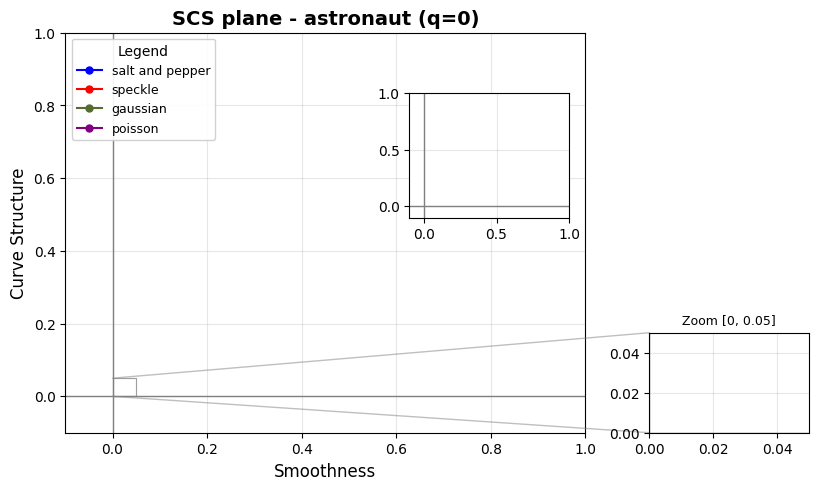

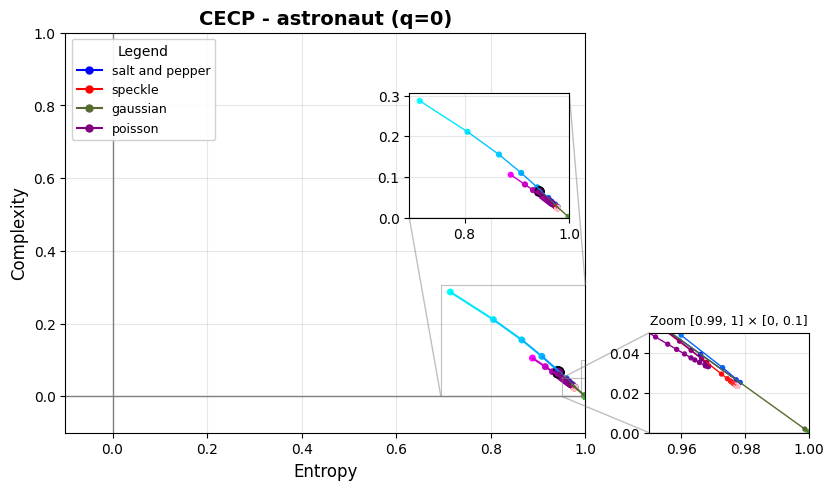

Plots created for astronaut


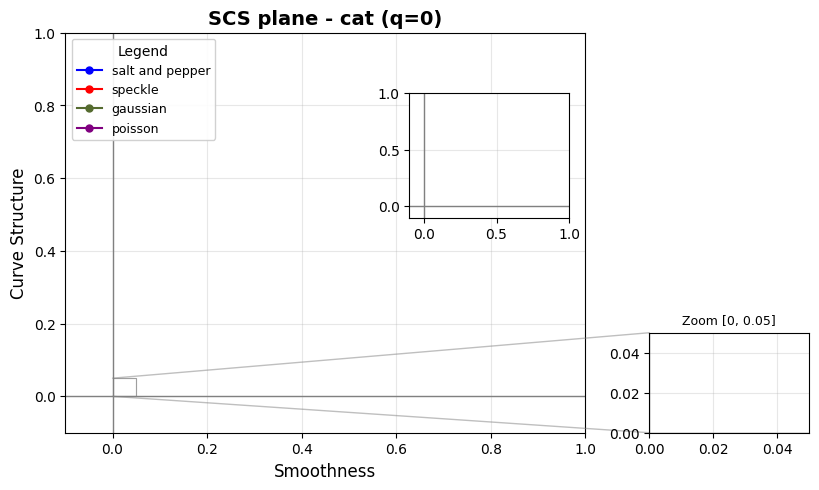

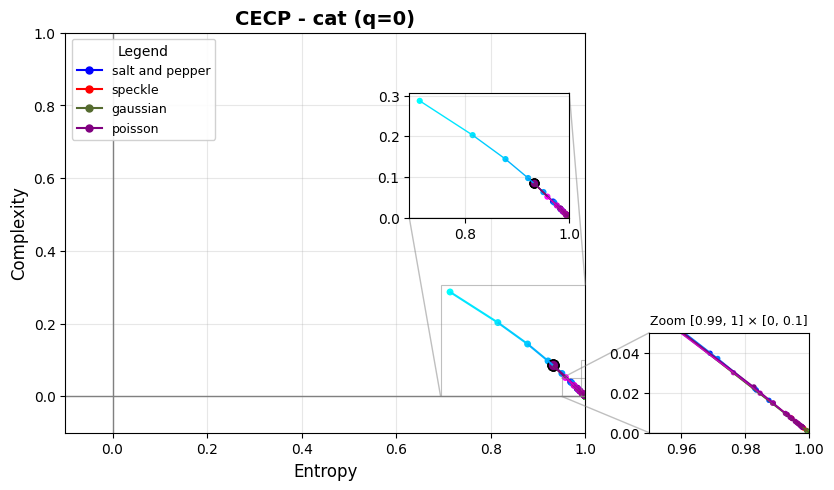

Plots created for cat


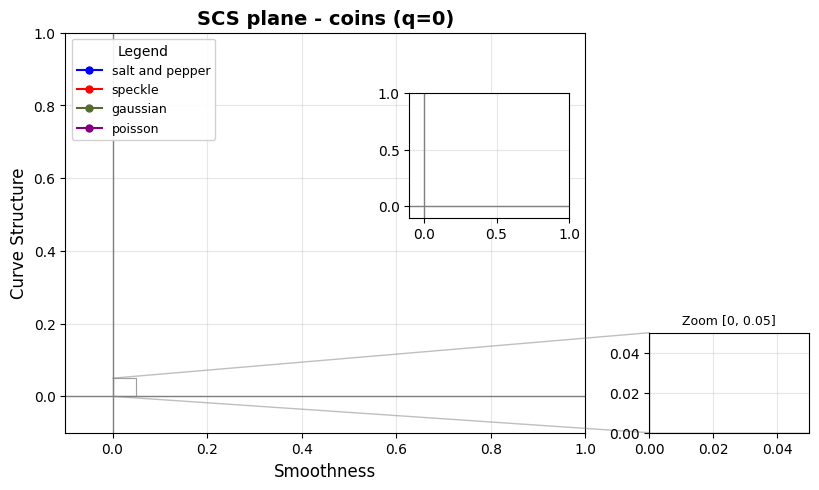

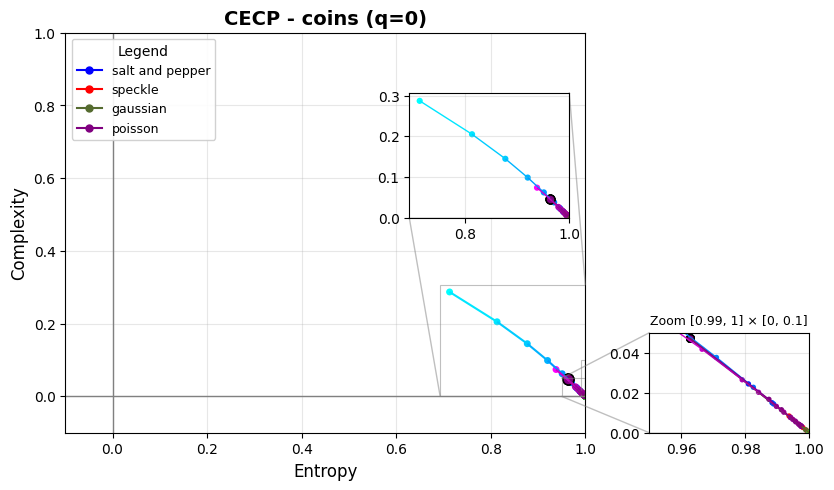

Plots created for coins


In [ ]:
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

# Define start and end colors for each noise type
noise_color_ranges = {
    'salt_and_pepper': ('blue', 'cyan'),
    'speckle': ('red', 'pink'),
    'gaussian': ('darkolivegreen', 'limegreen'),
    'poisson': ('purple', 'magenta')
}

# Process all images
noise_types = ['salt_and_pepper', 'speckle', 'gaussian', 'poisson']

for image_name, df in image_dataframes.items():
    image_name = image_name.split('.')[1] if image_name.split('.')[0] == 'data' else image_name
    # Clean up image name for display (remove file extension if present)
    display_name = image_name.split('.')[0] if '.' in image_name else image_name
    
    # First plot - SCSP (Smoothness vs Curve Structure)
    fig1 = plt.figure(figsize=(8, 5))  # Wider figure to accommodate external inset
    
    # Main plot in a central area
    ax_main = fig1.add_axes([0.12, 0.12, 0.65, 0.8])
    
    # Create data-range inset inside the main plot
    axins = plt.axes([0.55, 0.55, 0.2, 0.25], facecolor=ax_main.get_facecolor())
    
    # Create second inset outside and to the right of the main plot
    axins2 = fig1.add_axes([0.85, 0.12, 0.2, 0.2], facecolor=ax_main.get_facecolor())
    
    # Title and axis labels with image name
    ax_main.set_title(f'SCS plane - {display_name} (q=0)', fontsize=14, fontweight='bold')
    ax_main.set_xlabel('Smoothness', fontsize=12)
    ax_main.set_ylabel('Curve Structure', fontsize=12)
    
    # Set up axes for main plot and data-based inset
    for ax in [ax_main, axins]:
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([-0.1, 1]) 
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, lw=1, color='gray')
        ax.axvline(x=0, lw=1, color='gray')
    
    # Set up second inset for fixed [0, 0.05] range (SCS)
    axins2.set_xlim([0, 0.05])
    axins2.set_ylim([0, 0.05])
    axins2.grid(True, alpha=0.3)
    axins2.axhline(y=0, lw=1, color='gray')
    axins2.axvline(x=0, lw=1, color='gray')
    # Remove axis labels but keep ticks
    axins2.set_title("Zoom [0, 0.05]", fontsize=9)
    
    # Create plots for each noise type
    legend_handles = []
    legend_labels = []
    
    # Determine zoom region based on data
    all_x = []
    all_y = []
    
    for noise_type in noise_types:
        noise_data = df[df['noise_type'] == noise_type]
        if len(noise_data) == 0:
            continue
            
        # Sort by param value to ensure gradient goes in correct order
        noise_data = noise_data.sort_values('param')
        
        # Define start and end colors for this noise type
        start_color, end_color = noise_color_ranges[noise_type]
        
        # Create custom colormap for this noise type
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f"{noise_type}_cmap", [start_color, end_color]
        )
        norm = plt.Normalize(vmin=noise_data['param'].min(), vmax=noise_data['param'].max())
        
        # SCSP plot - Create gradient line collection with thinner lines
        x_vals = noise_data['Smoothness'].values
        y_vals = noise_data['Curve structure'].values
        all_x.extend(x_vals)
        all_y.extend(y_vals)
        
        points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Main plot with thinner lines
        lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1.5)
        lc.set_array(noise_data['param'].values)
        ax_main.add_collection(lc)
        
        # Inset plot with thinner lines
        lc_ins = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1)
        lc_ins.set_array(noise_data['param'].values)
        axins.add_collection(lc_ins)
        
        # Second inset (fixed [0, 0.05] range)
        lc_ins2 = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1)
        lc_ins2.set_array(noise_data['param'].values)
        axins2.add_collection(lc_ins2)
        
        # Scatter points with color gradient
        colors = cmap(norm(noise_data['param']))
        ax_main.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=25)
        axins.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=20)
        axins2.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=15)
        
        # Highlight original (no noise) data point if present
        no_noise_data = noise_data[noise_data['param'] == noise_data['param'].min()]
        if len(no_noise_data) > 0:
            ax_main.scatter(no_noise_data['Smoothness'], no_noise_data['Curve structure'],
                           c=start_color, edgecolors='black', marker='o', s=60)
            axins.scatter(no_noise_data['Smoothness'], no_noise_data['Curve structure'],
                         c=start_color, edgecolors='black', marker='o', s=40)
            axins2.scatter(no_noise_data['Smoothness'], no_noise_data['Curve structure'],
                          c=start_color, edgecolors='black', marker='o', s=30)
        
        # Add to legend
        legend_handles.append(plt.Line2D([0], [0], color=start_color, marker='o', 
                                       linestyle='-', markersize=5, linewidth=1.5))
        legend_labels.append(f"{noise_type.replace('_', ' ')}")
    
    # Configure first inset zoom area (data-based)
    if all_x and all_y:
        # Dynamic zoom based on data range
        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)
        
        # Add padding
        padding = 0.02
        
        axins.set_xlim(max(0, x_min - padding), min(1.0, x_max + padding))
        axins.set_ylim(max(0, y_min - padding), min(1.0, y_max + padding))
        
        # Mark the zoom area with a lighter, thinner connection
        ax_main.indicate_inset_zoom(axins, edgecolor='gray', alpha=0.5, linewidth=0.8)
    
    # Add indicate_inset_zoom for the second inset (fixed range)
    # Create a rectangle patch in the main plot showing the zoom region
    rect = plt.Rectangle((0, 0), 0.05, 0.05, 
                        fill=False, edgecolor='gray', linestyle='-', alpha=0.5, linewidth=0.8)
    ax_main.add_patch(rect)
    
    # Use indicate_inset_zoom to connect the rectangle to the external inset
    ax_main.indicate_inset_zoom(axins2, edgecolor='gray', alpha=0.5, linewidth=0.8)
    
    # Add legend to main plot
    ax_main.legend(legend_handles, legend_labels, loc='upper left', 
                  fontsize=9, framealpha=0.9, title='Legend', title_fontsize=10)
    
    # plt.savefig(f'results/qualificacao_noises/combined/{image_name}_scs_comparison.png', bbox_inches='tight', dpi=300)
    plt.show
    plt.close(fig1)
    
    # Second plot - CECP (Entropy vs Complexity)
    fig2 = plt.figure(figsize=(8, 5))  # Wider figure to accommodate external inset
    
    # Main plot in a central area
    ax_main = fig2.add_axes([0.12, 0.12, 0.65, 0.8])
    
    # Create data-range inset inside the main plot
    axins = plt.axes([0.55, 0.55, 0.2, 0.25], facecolor=ax_main.get_facecolor())
    
    # Create second inset outside and to the right of the main plot
    axins2 = fig2.add_axes([0.85, 0.12, 0.2, 0.2], facecolor=ax_main.get_facecolor())
    
    # Title and axis labels with image name
    ax_main.set_title(f'CECP - {display_name} (q=0)', fontsize=14, fontweight='bold')
    ax_main.set_xlabel('Entropy', fontsize=12)
    ax_main.set_ylabel('Complexity', fontsize=12)
    
    # Set up axes for main plot and data-based inset
    for ax in [ax_main, axins]:
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([-0.1, 1])
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, lw=1, color='gray')
        ax.axvline(x=0, lw=1, color='gray')
    
    # Set up second inset for CECP with specified ranges [0.99, 1] x [0, 0.1]
    axins2.set_xlim([0.95, 1])
    axins2.set_ylim([0, 0.05])
    axins2.grid(True, alpha=0.3)
    axins2.axhline(y=0, lw=1, color='gray')
    # No need for vertical line at x=0 since it's out of the range
    if 0.99 <= 0 <= 1:
        axins2.axvline(x=0, lw=1, color='gray')
    # Remove axis labels but keep ticks
    axins2.set_title("Zoom [0.99, 1] × [0, 0.1]", fontsize=9)
    
    # Create plots for each noise type
    legend_handles = []
    legend_labels = []
    
    # Determine zoom region based on data
    all_x = []
    all_y = []
    
    for noise_type in noise_types:
        noise_data = df[df['noise_type'] == noise_type]
        if len(noise_data) == 0:
            continue
            
        # Sort by param value to ensure gradient goes in correct order
        noise_data = noise_data.sort_values('param')
        
        # Define start and end colors for this noise type
        start_color, end_color = noise_color_ranges[noise_type]
        
        # Create custom colormap for this noise type
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f"{noise_type}_cmap", [start_color, end_color]
        )
        norm = plt.Normalize(vmin=noise_data['param'].min(), vmax=noise_data['param'].max())
        
        # CECP plot - Create gradient line collection with thinner lines
        x_vals = noise_data['Weighted Entropy Correct'].values
        y_vals = noise_data['Weighted Complexity Correct'].values
        all_x.extend(x_vals)
        all_y.extend(y_vals)
        
        points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Main plot with thinner lines
        lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1.5)
        lc.set_array(noise_data['param'].values)
        ax_main.add_collection(lc)
        
        # Inset plot with thinner lines
        lc_ins = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1)
        lc_ins.set_array(noise_data['param'].values)
        axins.add_collection(lc_ins)
        
        # Second inset with specified ranges
        lc_ins2 = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1)
        lc_ins2.set_array(noise_data['param'].values)
        axins2.add_collection(lc_ins2)
        
        # Scatter points with color gradient
        colors = cmap(norm(noise_data['param']))
        ax_main.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=25)
        axins.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=20)
        axins2.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=15)
        
        # Highlight original (no noise) data point if present
        no_noise_data = noise_data[noise_data['param'] == noise_data['param'].min()]
        if len(no_noise_data) > 0:
            ax_main.scatter(no_noise_data['Weighted Entropy Correct'], no_noise_data['Weighted Complexity Correct'],
                           c=start_color, edgecolors='black', marker='o', s=60)
            axins.scatter(no_noise_data['Weighted Entropy Correct'], no_noise_data['Weighted Complexity Correct'],
                         c=start_color, edgecolors='black', marker='o', s=40)
            axins2.scatter(no_noise_data['Weighted Entropy Correct'], no_noise_data['Weighted Complexity Correct'],
                          c=start_color, edgecolors='black', marker='o', s=30)
        
        # Add to legend
        legend_handles.append(plt.Line2D([0], [0], color=start_color, marker='o', 
                                       linestyle='-', markersize=5, linewidth=1.5))
        legend_labels.append(f"{noise_type.replace('_', ' ')}")
    
    # Configure first inset zoom area (data-based)
    if all_x and all_y:
        # Dynamic zoom based on data range
        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)
        
        # Add padding
        padding = 0.02
        
        axins.set_xlim(max(0, x_min - padding), min(1.0, x_max + padding))
        axins.set_ylim(max(0, y_min - padding), min(1.0, y_max + padding))
        
        # Mark the zoom area with a lighter connection
        ax_main.indicate_inset_zoom(axins, edgecolor='gray', alpha=0.5, linewidth=0.8)
    
    # Add indicate_inset_zoom for the second inset (fixed range)
    # Create a rectangle patch in the main plot showing the zoom region
    rect = plt.Rectangle((0.99, 0), 0.01, 0.1, 
                        fill=False, edgecolor='gray', linestyle='-', alpha=0.5, linewidth=0.8)
    ax_main.add_patch(rect)
    
    # Use indicate_inset_zoom to connect the rectangle to the external inset
    ax_main.indicate_inset_zoom(axins2, edgecolor='gray', alpha=0.5, linewidth=0.8)
    
    # Add legend to main plot
    ax_main.legend(legend_handles, legend_labels, loc='upper left', 
                  fontsize=9, framealpha=0.9, title='Legend', title_fontsize=10)
    
    # plt.savefig(f'results/qualificacao_noises/combined/{image_name}_cecp_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig2)
    
    print(f"Plots created for {image_name}")

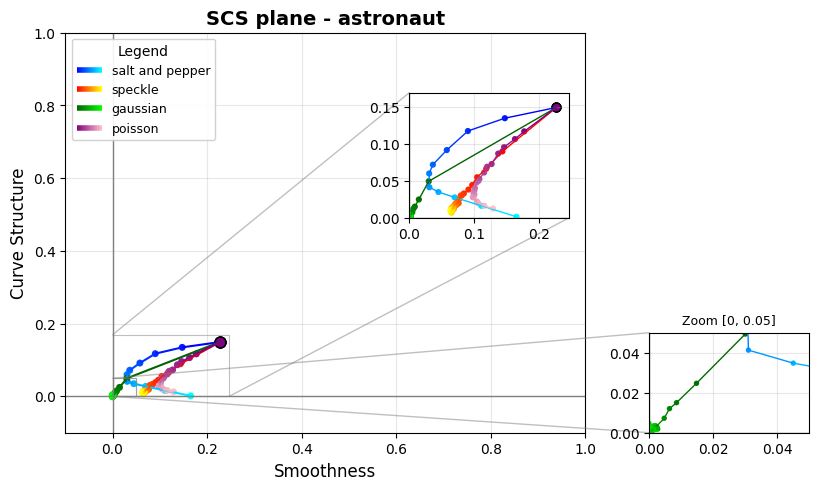

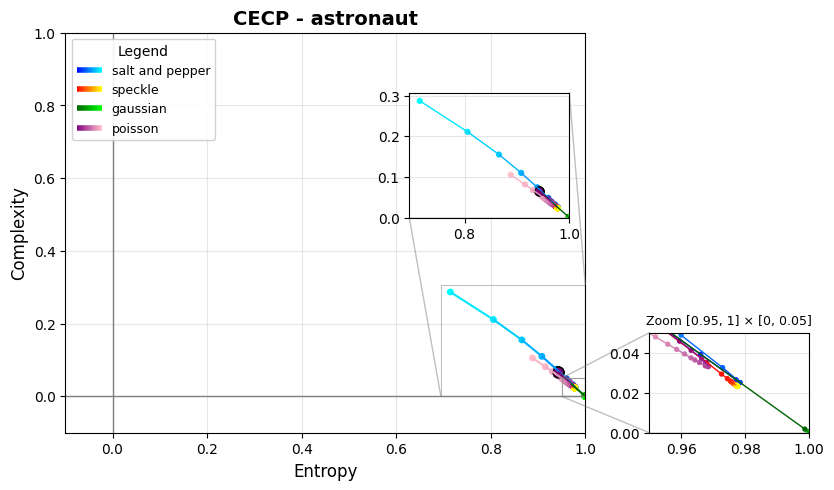

Plots created for astronaut


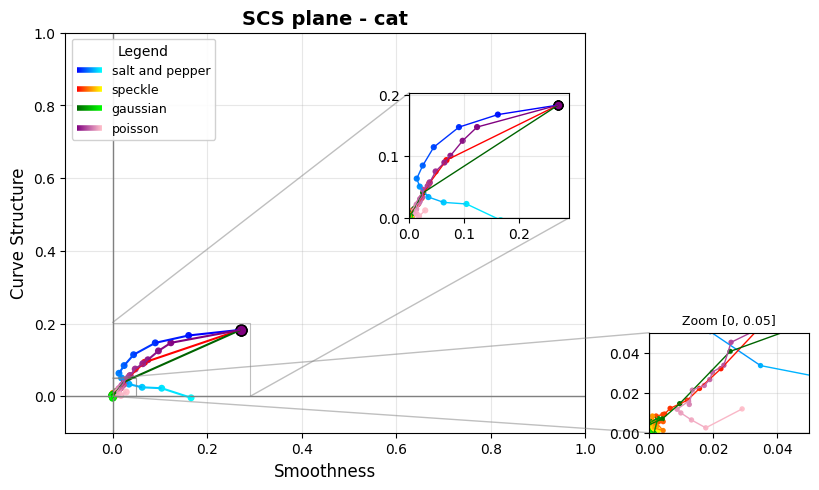

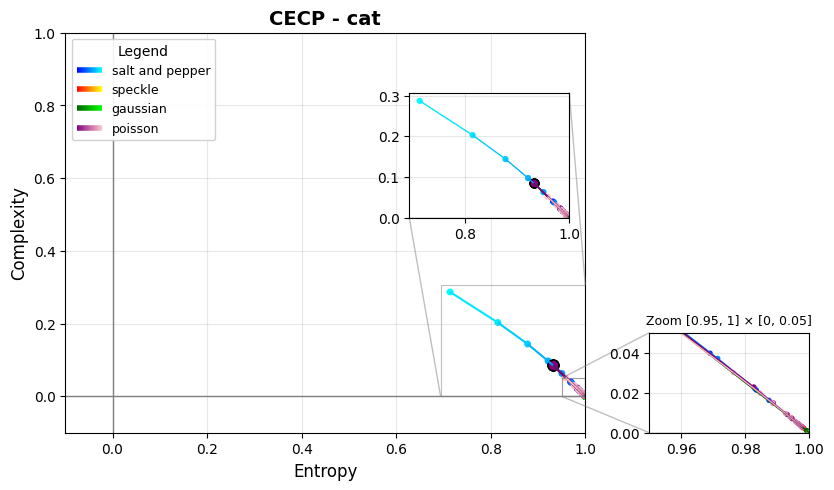

Plots created for cat


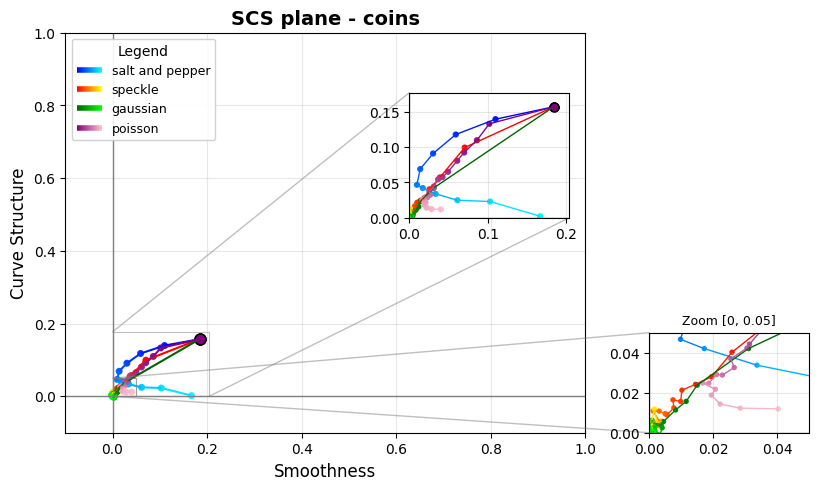

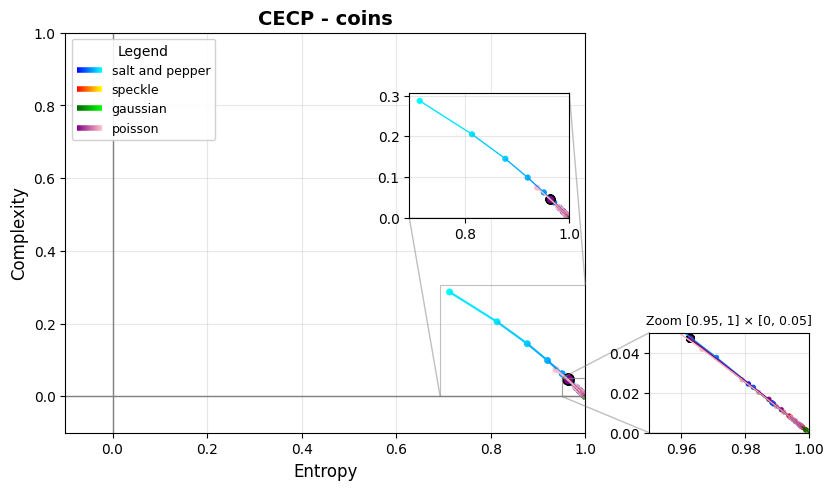

Plots created for coins


In [21]:
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase

# Define a custom handler for LineCollection objects in the legend
class HandlerLineCollection(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        x = np.linspace(0, width, 100)
        y = np.zeros_like(x) + height/2
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create a new LineCollection with the same properties
        lc = LineCollection(segments, cmap=orig_handle.cmap,
                           norm=orig_handle.norm,
                           linewidth=orig_handle.get_linewidth())
        
        # Use a consistent array range for all legends
        lc.set_array(np.linspace(0, 1, 100))
        
        return [lc]

# Define start and end colors for each noise type
noise_color_ranges = {
    'salt_and_pepper': ('blue', 'cyan'),
    'speckle': ('red', 'yellow'),
    'gaussian': ('darkgreen', 'lime'),
    'poisson': ('purple', 'pink')
}

# Process all images
noise_types = ['salt_and_pepper', 'speckle', 'gaussian', 'poisson']

for image_name, df in image_dataframes.items():
    image_name = image_name.split('.')[1] if image_name.split('.')[0] == 'data' else image_name
    # Clean up image name for display (remove file extension if present)
    display_name = image_name.split('.')[0] if '.' in image_name else image_name
    
    # First plot - SCSP (Smoothness vs Curve Structure)
    fig1 = plt.figure(figsize=(8, 5))  # Wider figure to accommodate external inset
    
    # Main plot in a central area
    ax_main = fig1.add_axes([0.12, 0.12, 0.65, 0.8])
    
    # Create data-range inset inside the main plot
    axins = plt.axes([0.55, 0.55, 0.2, 0.25], facecolor=ax_main.get_facecolor())
    
    # Create second inset outside and to the right of the main plot
    axins2 = fig1.add_axes([0.85, 0.12, 0.2, 0.2], facecolor=ax_main.get_facecolor())
    
    # Title and axis labels with image name
    ax_main.set_title(f'SCS plane - {display_name}', fontsize=14, fontweight='bold')
    ax_main.set_xlabel('Smoothness', fontsize=12)
    ax_main.set_ylabel('Curve Structure', fontsize=12)
    
    # Set up axes for main plot and data-based inset
    for ax in [ax_main, axins]:
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([-0.1, 1]) 
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, lw=1, color='gray')
        ax.axvline(x=0, lw=1, color='gray')
    
    # Set up second inset for fixed [0, 0.05] range (SCS)
    axins2.set_xlim([0, 0.05])
    axins2.set_ylim([0, 0.05])
    axins2.grid(True, alpha=0.3)
    axins2.axhline(y=0, lw=1, color='gray')
    axins2.axvline(x=0, lw=1, color='gray')
    # Remove axis labels but keep ticks
    axins2.set_title("Zoom [0, 0.05]", fontsize=9)
    
    # Create plots for each noise type
    legend_handles = []
    legend_labels = []
    
    # Determine zoom region based on data
    all_x = []
    all_y = []
    
    for noise_type in noise_types:
        noise_data = df[df['noise_type'] == noise_type]
        if len(noise_data) == 0:
            continue
            
        # Sort by param value to ensure gradient goes in correct order
        noise_data = noise_data.sort_values('param')
        
        # Define start and end colors for this noise type
        start_color, end_color = noise_color_ranges[noise_type]
        
        # Create custom colormap for this noise type
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f"{noise_type}_cmap", [start_color, end_color]
        )
        
        # Get unique parameter values
        unique_params = noise_data['param'].unique()
        num_params = len(unique_params)
        
        # Create normalized values based on the index of unique parameters
        # This creates an evenly spaced sequence regardless of actual param values
        param_indices = {param: idx/(num_params-1) if num_params > 1 else 0 
                        for idx, param in enumerate(sorted(unique_params))}
        
        # Map each parameter to its normalized index value
        norm_param_values = np.array([param_indices[p] for p in noise_data['param']])
        
        # Create a normalized colormap from 0 to 1 for any number of params
        norm = plt.Normalize(0, 1)
        
        # SCSP plot - Create gradient line collection with thinner lines
        x_vals = noise_data['Smoothness'].values
        y_vals = noise_data['Curve structure'].values
        all_x.extend(x_vals)
        all_y.extend(y_vals)
        
        points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Main plot with thinner lines
        lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1.5)
        lc.set_array(norm_param_values)
        ax_main.add_collection(lc)
        
        # Inset plot with thinner lines
        lc_ins = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1)
        lc_ins.set_array(norm_param_values)
        axins.add_collection(lc_ins)
        
        # Second inset (fixed [0, 0.05] range)
        lc_ins2 = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1)
        lc_ins2.set_array(norm_param_values)
        axins2.add_collection(lc_ins2)
        
        # Scatter points with color gradient
        colors = cmap(norm(norm_param_values))
        ax_main.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=25)
        axins.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=20)
        axins2.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=15)
        
        # Highlight original (no noise) data point if present
        no_noise_data = noise_data[noise_data['param'] == unique_params[0]] # use first param as original
        if len(no_noise_data) > 0:
            ax_main.scatter(no_noise_data['Smoothness'], no_noise_data['Curve structure'],
                           c=start_color, edgecolors='black', marker='o', s=60)
            axins.scatter(no_noise_data['Smoothness'], no_noise_data['Curve structure'],
                         c=start_color, edgecolors='black', marker='o', s=40)
            axins2.scatter(no_noise_data['Smoothness'], no_noise_data['Curve structure'],
                          c=start_color, edgecolors='black', marker='o', s=30)
        
        # Create a gradient line specifically for the legend
        gradient_x = np.linspace(0, 1, 100)
        gradient_y = np.ones_like(gradient_x) * 0.5
        gradient_points = np.array([gradient_x, gradient_y]).T.reshape(-1, 1, 2)
        gradient_segments = np.concatenate([gradient_points[:-1], gradient_points[1:]], axis=1)
        
        # Create a LineCollection for the legend with explicit gradient
        legend_lc = LineCollection(gradient_segments, linewidth=4)
        legend_lc.set_cmap(cmap)
        legend_lc.set_norm(norm)
        
        # Set array to a simple 0-1 range for consistent gradient display
        legend_lc.set_array(np.linspace(0, 1, 100))
        
        # Store cmap and norm as attributes for the handler to access    
        legend_lc.cmap = cmap
        legend_lc.norm = norm
        
        # Add to legend with the gradient LineCollection
        legend_handles.append(legend_lc)
        legend_labels.append(f"{noise_type.replace('_', ' ')}")
    
    # Configure first inset zoom area (data-based)
    if all_x and all_y:
        # Dynamic zoom based on data range
        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)
        
        # Add padding
        padding = 0.02
        
        axins.set_xlim(max(0, x_min - padding), min(1.0, x_max + padding))
        axins.set_ylim(max(0, y_min - padding), min(1.0, y_max + padding))
        
        # Mark the zoom area with a lighter, thinner connection
        ax_main.indicate_inset_zoom(axins, edgecolor='gray', alpha=0.5, linewidth=0.8)
    
    # Add indicate_inset_zoom for the second inset (fixed range)
    # Create a rectangle patch in the main plot showing the zoom region
    rect = plt.Rectangle((0, 0), 0.05, 0.05, 
                        fill=False, edgecolor='gray', linestyle='-', alpha=0.5, linewidth=0.8)
    ax_main.add_patch(rect)
    
    # Use indicate_inset_zoom to connect the rectangle to the external inset
    ax_main.indicate_inset_zoom(axins2, edgecolor='gray', alpha=0.5, linewidth=0.8)
    
    # Add legend to main plot with custom handler for LineCollection objects
    ax_main.legend(legend_handles, legend_labels, loc='upper left', 
                  fontsize=9, framealpha=0.9, title='Legend', title_fontsize=10,
                  handler_map={LineCollection: HandlerLineCollection()})
    
    plt.savefig(f'results/qualificacao_noises/combined/{image_name}_scs_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig1)
    
    # Second plot - CECP (Entropy vs Complexity)
    fig2 = plt.figure(figsize=(8, 5))  # Wider figure to accommodate external inset
    
    # Main plot in a central area
    ax_main = fig2.add_axes([0.12, 0.12, 0.65, 0.8])
    
    # Create data-range inset inside the main plot
    axins = plt.axes([0.55, 0.55, 0.2, 0.25], facecolor=ax_main.get_facecolor())
    
    # Create second inset outside and to the right of the main plot
    axins2 = fig2.add_axes([0.85, 0.12, 0.2, 0.2], facecolor=ax_main.get_facecolor())
    
    # Title and axis labels with image name
    ax_main.set_title(f'CECP - {display_name}', fontsize=14, fontweight='bold')
    ax_main.set_xlabel('Entropy', fontsize=12)
    ax_main.set_ylabel('Complexity', fontsize=12)
    
    # Set up axes for main plot and data-based inset
    for ax in [ax_main, axins]:
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([-0.1, 1])
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, lw=1, color='gray')
        ax.axvline(x=0, lw=1, color='gray')
    
    # Set up second inset for CECP with specified ranges [0.95, 1] x [0, 0.05]
    axins2.set_xlim([0.95, 1])
    axins2.set_ylim([0, 0.05])
    axins2.grid(True, alpha=0.3)
    axins2.axhline(y=0, lw=1, color='gray')
    # No need for vertical line at x=0 since it's out of the range
    if 0.95 <= 0 <= 1:
        axins2.axvline(x=0, lw=1, color='gray')
    # Remove axis labels but keep ticks
    axins2.set_title("Zoom [0.95, 1] × [0, 0.05]", fontsize=9)
    
    # Create plots for each noise type
    legend_handles = []
    legend_labels = []
    
    # Determine zoom region based on data
    all_x = []
    all_y = []
    
    for noise_type in noise_types:
        noise_data = df[df['noise_type'] == noise_type]
        if len(noise_data) == 0:
            continue
            
        # Sort by param value to ensure gradient goes in correct order
        noise_data = noise_data.sort_values('param')
        
        # Define start and end colors for this noise type
        start_color, end_color = noise_color_ranges[noise_type]
        
        # Create custom colormap for this noise type
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f"{noise_type}_cmap", [start_color, end_color]
        )
        
        # Get unique parameter values
        unique_params = noise_data['param'].unique()
        num_params = len(unique_params)
        
        # Create normalized values based on the index of unique parameters
        # This creates an evenly spaced sequence regardless of actual param values
        param_indices = {param: idx/(num_params-1) if num_params > 1 else 0 
                        for idx, param in enumerate(sorted(unique_params))}
        
        # Map each parameter to its normalized index value
        norm_param_values = np.array([param_indices[p] for p in noise_data['param']])
        
        # Create a normalized colormap from 0 to 1 for any number of params
        norm = plt.Normalize(0, 1)
        
        # CECP plot - Create gradient line collection with thinner lines
        x_vals = noise_data['Weighted Entropy Correct'].values
        y_vals = noise_data['Weighted Complexity Correct'].values
        all_x.extend(x_vals)
        all_y.extend(y_vals)
        
        points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Main plot with thinner lines
        lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1.5)
        lc.set_array(norm_param_values)
        ax_main.add_collection(lc)
        
        # Inset plot with thinner lines
        lc_ins = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1)
        lc_ins.set_array(norm_param_values)
        axins.add_collection(lc_ins)
        
        # Second inset with specified ranges
        lc_ins2 = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1)
        lc_ins2.set_array(norm_param_values)
        axins2.add_collection(lc_ins2)
        
        # Scatter points with color gradient
        colors = cmap(norm(norm_param_values))
        ax_main.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=25)
        axins.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=20)
        axins2.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=15)
        
        # Highlight original (no noise) data point if present
        no_noise_data = noise_data[noise_data['param'] == unique_params[0]] # use first param as original
        if len(no_noise_data) > 0:
            ax_main.scatter(no_noise_data['Weighted Entropy Correct'], no_noise_data['Weighted Complexity Correct'],
                           c=start_color, edgecolors='black', marker='o', s=60)
            axins.scatter(no_noise_data['Weighted Entropy Correct'], no_noise_data['Weighted Complexity Correct'],
                         c=start_color, edgecolors='black', marker='o', s=40)
            axins2.scatter(no_noise_data['Weighted Entropy Correct'], no_noise_data['Weighted Complexity Correct'],
                          c=start_color, edgecolors='black', marker='o', s=30)
        
        # Create a gradient line specifically for the legend
        gradient_x = np.linspace(0, 1, 100)
        gradient_y = np.ones_like(gradient_x) * 0.5
        gradient_points = np.array([gradient_x, gradient_y]).T.reshape(-1, 1, 2)
        gradient_segments = np.concatenate([gradient_points[:-1], gradient_points[1:]], axis=1)
        
        # Create a LineCollection for the legend with explicit gradient
        legend_lc = LineCollection(gradient_segments, linewidth=4)
        legend_lc.set_cmap(cmap)
        legend_lc.set_norm(norm)
        
        # Set array to a simple 0-1 range for consistent gradient display
        legend_lc.set_array(np.linspace(0, 1, 100))
        
        # Store cmap and norm as attributes for the handler to access    
        legend_lc.cmap = cmap
        legend_lc.norm = norm
        
        # Add to legend with the gradient LineCollection
        legend_handles.append(legend_lc)
        legend_labels.append(f"{noise_type.replace('_', ' ')}")
    
    # Configure first inset zoom area (data-based)
    if all_x and all_y:
        # Dynamic zoom based on data range
        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)
        
        # Add padding
        padding = 0.02
        
        axins.set_xlim(max(0, x_min - padding), min(1.0, x_max + padding))
        axins.set_ylim(max(0, y_min - padding), min(1.0, y_max + padding))
        
        # Mark the zoom area with a lighter connection
        ax_main.indicate_inset_zoom(axins, edgecolor='gray', alpha=0.5, linewidth=0.8)
    
    # Add indicate_inset_zoom for the second inset (fixed range)
    # Create a rectangle patch in the main plot showing the zoom region
    rect = plt.Rectangle((0.95, 0), 0.05, 0.05, 
                        fill=False, edgecolor='gray', linestyle='-', alpha=0.5, linewidth=0.8)
    ax_main.add_patch(rect)
    
    # Use indicate_inset_zoom to connect the rectangle to the external inset
    ax_main.indicate_inset_zoom(axins2, edgecolor='gray', alpha=0.5, linewidth=0.8)
    
    # Add legend to main plot with custom handler for LineCollection objects
    ax_main.legend(legend_handles, legend_labels, loc='upper left', 
                  fontsize=9, framealpha=0.9, title='Legend', title_fontsize=10,
                  handler_map={LineCollection: HandlerLineCollection()})
    
    plt.savefig(f'results/qualificacao_noises/combined/{image_name}_cecp_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig2)
    
    print(f"Plots created for {image_name}")

### 2D plots - Variations

In [8]:
### 2D plots - All Metric Combinations

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import os

# Create directory for saving if it doesn't exist
os.makedirs('results/qualificacao_noises/2d_combinations', exist_ok=True)

# Define all metrics with simplified names
metric_display_names = {
    'Smoothness': 'Smoothness',
    'Curve structure': 'Curve Structure',
    'Weighted Entropy Correct': 'Entropy',
    'Weighted Complexity Correct': 'Complexity'
}

# Define all metrics
metrics = ['Smoothness', 'Curve structure', 'Weighted Entropy Correct', 'Weighted Complexity Correct']

# Generate all possible 2D combinations of metrics
metric_combinations = []
for i in range(len(metrics)):
    for j in range(i+1, len(metrics)):
        metric_combinations.append((metrics[i], metrics[j]))

# Define start and end colors for each noise type (reuse from previous section)
noise_color_ranges = {
    'salt_and_pepper': ('blue', 'cyan'),
    'speckle': ('red', 'pink'),
    'gaussian': ('darkolivegreen', 'limegreen'),
    'poisson': ('purple', 'magenta')
}

# Create plots for each image and metric combination
for image_name, df in image_dataframes.items():
    # Clean up image name for display
    display_name = image_name.split('.')[1] if image_name.split('.')[0] == 'data' else image_name
    display_name = display_name.split('.')[0] if '.' in display_name else display_name
    
    # Create a figure for all metric combinations for this image
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
    axs = axs.flatten()  # Flatten to easily iterate
    
    # Generate each combination plot
    for idx, (x_metric, y_metric) in enumerate(metric_combinations):
        ax = axs[idx]
        
        # Set up the basic plot with simplified display names
        ax.set_title(f'{metric_display_names[x_metric]} vs {metric_display_names[y_metric]}', fontsize=12)
        ax.set_xlabel(metric_display_names[x_metric], fontsize=10)
        ax.set_ylabel(metric_display_names[y_metric], fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, lw=1, color='gray')
        ax.axvline(x=0, lw=1, color='gray')
        
        # Process each noise type
        legend_handles = []
        legend_labels = []
        
        for noise_type in noise_types:
            noise_data = df[df['noise_type'] == noise_type]
            if len(noise_data) == 0:
                continue
                
            # Sort by param value to ensure gradient goes in correct order
            noise_data = noise_data.sort_values('param')
            
            # Define start and end colors for this noise type
            start_color, end_color = noise_color_ranges[noise_type]
            
            # Create custom colormap for this noise type
            cmap = mcolors.LinearSegmentedColormap.from_list(
                f"{noise_type}_cmap", [start_color, end_color]
            )
            norm = plt.Normalize(vmin=noise_data['param'].min(), vmax=noise_data['param'].max())
            
            # Get data values
            x_vals = noise_data[x_metric].values
            y_vals = noise_data[y_metric].values
            
            # Create gradient colored line
            points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            # Add line collection
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=1.5)
            lc.set_array(noise_data['param'].values)
            ax.add_collection(lc)
            
            # Add scatter points with color gradient
            colors = cmap(norm(noise_data['param']))
            ax.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=20, alpha=0.8)
            
            # Highlight original (no noise) data point if present
            no_noise_data = noise_data[noise_data['param'] == noise_data['param'].min()]
            if len(no_noise_data) > 0:
                ax.scatter(
                    no_noise_data[x_metric], 
                    no_noise_data[y_metric],
                    c=start_color, 
                    edgecolors='black', 
                    marker='o', 
                    s=50
                )
            
            # Add to legend
            legend_handles.append(plt.Line2D([0], [0], color=start_color, marker='o', 
                                           linestyle='-', markersize=5, linewidth=1.5))
            legend_labels.append(f"{noise_type.replace('_', ' ')}")
        
        # Add legend to each subplot
        if idx == 0:  # Only add legend to first plot to avoid redundancy
            ax.legend(legend_handles, legend_labels, loc='best', 
                     fontsize=8, framealpha=0.7)
        
        # Set axis limits with a bit of padding
        x_vals_all = df[x_metric].values
        y_vals_all = df[y_metric].values
        
        # Add padding to axes
        x_range = max(x_vals_all) - min(x_vals_all)
        y_range = max(y_vals_all) - min(y_vals_all)
        
        padding = 0.05
        ax.set_xlim(max(-0.1, min(x_vals_all) - padding * x_range), 
                   min(1.0, max(x_vals_all) + padding * x_range))
        ax.set_ylim(max(-0.1, min(y_vals_all) - padding * y_range), 
                   min(1.0, max(y_vals_all) + padding * y_range))
    
    # Set main title for the figure
    fig.suptitle(f'Metric Relationships for {display_name} Under Different Noise Types', 
                fontsize=16, fontweight='bold')
    
    # Add common legend to figure
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(noise_types), 
              bbox_to_anchor=(0.5, 0.02), fontsize=10)
    
    # Remove any empty subplots
    if len(metric_combinations) < len(axs):
        for i in range(len(metric_combinations), len(axs)):
            fig.delaxes(axs[i])
    
    # Save figure
    plt.savefig(f'results/qualificacao_noises/2d_combinations/{display_name}_all_metric_combinations.png', 
               bbox_inches='tight', dpi=300)
    plt.close(fig)
    
    print(f"Created 2D combination plots for {display_name}")

    # Generate individual plots for each metric combination (larger, more detailed)
    for x_metric, y_metric in metric_combinations:
        # Create a clean metric name for file saving
        x_name = x_metric.replace(' ', '_').lower()
        y_name = y_metric.replace(' ', '_').lower()
        
        # Use simplified display names
        x_display = metric_display_names[x_metric]
        y_display = metric_display_names[y_metric]
        
        fig, ax = plt.figure(figsize=(10, 8)), plt.gca()
        
        # Set plot title and labels with simplified names
        ax.set_title(f'{x_display} vs {y_display} - {display_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel(x_display, fontsize=12)
        ax.set_ylabel(y_display, fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, lw=1, color='gray')
        ax.axvline(x=0, lw=1, color='gray')
        
        # Process each noise type
        legend_handles = []
        legend_labels = []
        
        for noise_type in noise_types:
            noise_data = df[df['noise_type'] == noise_type]
            if len(noise_data) == 0:
                continue
                
            # Sort by param value
            noise_data = noise_data.sort_values('param')
            
            # Get colors
            start_color, end_color = noise_color_ranges[noise_type]
            cmap = mcolors.LinearSegmentedColormap.from_list(
                f"{noise_type}_cmap", [start_color, end_color]
            )
            norm = plt.Normalize(vmin=noise_data['param'].min(), vmax=noise_data['param'].max())
            
            # Get data values
            x_vals = noise_data[x_metric].values
            y_vals = noise_data[y_metric].values
            
            # Create gradient colored line
            points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            # Add line collection
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=2.0)
            lc.set_array(noise_data['param'].values)
            ax.add_collection(lc)
            
            # Add scatter points with color gradient
            colors = cmap(norm(noise_data['param']))
            ax.scatter(x_vals, y_vals, c=colors, edgecolors='none', marker='o', s=30, alpha=0.8)
            
            # Removed colorbar code to eliminate parameter bars
            
            # Highlight original (no noise) data point if present
            no_noise_data = noise_data[noise_data['param'] == noise_data['param'].min()]
            if len(no_noise_data) > 0:
                ax.scatter(
                    no_noise_data[x_metric], 
                    no_noise_data[y_metric],
                    c=start_color, 
                    edgecolors='black', 
                    marker='o', 
                    s=80
                )
            
            # Add to legend
            legend_handles.append(plt.Line2D([0], [0], color=start_color, marker='o', 
                                           linestyle='-', markersize=6, linewidth=2.0))
            legend_labels.append(f"{noise_type.replace('_', ' ')}")
        
        # Add legend
        ax.legend(legend_handles, legend_labels, loc='best', 
                 fontsize=10, framealpha=0.9, title="Noise Types")
        
        # Set axis limits with a bit of padding
        x_vals_all = df[x_metric].values
        y_vals_all = df[y_metric].values
        
        x_range = max(x_vals_all) - min(x_vals_all)
        y_range = max(y_vals_all) - min(y_vals_all)
        
        padding = 0.1
        ax.set_xlim(max(-0.1, min(x_vals_all) - padding * x_range), 
                   min(1.0, max(x_vals_all) + padding * x_range))
        ax.set_ylim(max(-0.1, min(y_vals_all) - padding * y_range), 
                   min(1.0, max(y_vals_all) + padding * y_range))
        
        # Save individual plot with simplified metric names in filename
        simplified_x_name = x_display.replace(' ', '_').lower()
        simplified_y_name = y_display.replace(' ', '_').lower()
        
        plt.savefig(f'results/qualificacao_noises/2d_combinations/{display_name}_{simplified_x_name}_vs_{simplified_y_name}.png', 
                   bbox_inches='tight', dpi=300)
        plt.close(fig)

Created 2D combination plots for astronaut
Created 2D combination plots for cat
Created 2D combination plots for coins


### 3D html plots

In [8]:
from plotly.subplots import make_subplots
import numpy as np
import os

import plotly.graph_objects as go

# Create directory for saving if it doesn't exist
os.makedirs('results/qualificacao_noises/interactive_3d', exist_ok=True)

# Define colors for each noise type
noise_colors = {
    'salt_and_pepper': 'blue',
    'speckle': 'red',
    'gaussian': 'green',
    'poisson': 'purple'
}

# Define metric combinations to plot
metric_combinations = [
    ('Smoothness', 'Curve structure', 'Weighted Entropy Correct', 'Entropy'),
    ('Smoothness', 'Curve structure', 'Weighted Complexity Correct', 'Complexity'),
    ('Smoothness', 'Weighted Entropy Correct', 'Weighted Complexity Correct', 'Entropy-Complexity'),
    ('Curve structure', 'Weighted Entropy Correct', 'Weighted Complexity Correct', 'Structure-Entropy-Complexity')
]

# Process all images
for image_name, df in image_dataframes.items():
    # Clean up image name for display
    display_name = image_name.split('.')[1] if image_name.split('.')[0] == 'data' else image_name
    display_name = display_name.split('.')[0] if '.' in display_name else display_name
    
    # Create plots for each metric combination
    for x_metric, y_metric, z_metric, combo_name in metric_combinations:
        # Create figure
        fig = go.Figure()
        
        # Process each noise type
        for noise_type in noise_types:
            noise_df = df[df['noise_type'] == noise_type]
            if len(noise_df) == 0:
                continue
                
            # Sort by parameter value to ensure curve is drawn correctly
            noise_df = noise_df.sort_values('param')
            
            # Get parameter values for size scaling
            param_values = noise_df['param'].values
            normalized_sizes = 5 + 15 * (param_values - param_values.min()) / (param_values.max() - param_values.min() + 1e-10)
            
            # Create 3D scatter plot with lines
            fig.add_trace(go.Scatter3d(
                x=noise_df[x_metric],
                y=noise_df[y_metric],
                z=noise_df[z_metric],
                mode='lines+markers',
                name=noise_type.replace('_', ' ').title(),
                line=dict(color=noise_colors[noise_type], width=3),
                marker=dict(
                    size=normalized_sizes,
                    color=noise_colors[noise_type],
                    opacity=0.8
                ),
                text=[f"Parameter: {p:.2f}<br>{x_metric}: {x:.4f}<br>{y_metric}: {y:.4f}<br>{z_metric}: {z:.4f}" 
                      for p, x, y, z in zip(
                          noise_df['param'], 
                          noise_df[x_metric],
                          noise_df[y_metric],
                          noise_df[z_metric]
                      )],
                hoverinfo='text'
            ))
        
        # Update layout for better visualization
        fig.update_layout(
            title=f'3D Noise Analysis - {display_name} - {combo_name}',
            scene=dict(
                xaxis_title=x_metric,
                yaxis_title=y_metric,
                zaxis_title=z_metric,
                aspectmode='manual',
                aspectratio=dict(x=1, y=1, z=1)
            ),
            width=1000,
            height=800,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            )
        )
        
        # Add buttons to show/hide specific noise types
        updatemenus = []
        
        # Add dropdown for noise types
        noise_buttons = []
        for nt in noise_types:
            noise_buttons.append(
                dict(
                    args=[{'visible': [noise == nt for noise in noise_types]}],
                    label=f"Show {nt.replace('_', ' ').title()}",
                    method="update"
                )
            )
        
        # Add button to show all noise types
        noise_buttons.append(
            dict(
                args=[{'visible': [True] * len(noise_types)}],
                label="Show All",
                method="update"
            )
        )
        
        updatemenus.append(
            dict(
                buttons=noise_buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.15,
                yanchor="top",
                bgcolor="white",
                bordercolor="gray",
                font=dict(color="black")
            )
        )
        
        fig.update_layout(updatemenus=updatemenus)
        
        # Save as interactive HTML
        fig.write_html(f'results/qualificacao_noises/interactive_3d/{display_name}_3d_interactive_{combo_name}.html')
        
        # Print status
        print(f"Created interactive 3D plot for {display_name} - {combo_name}")

Created interactive 3D plot for astronaut - Entropy
Created interactive 3D plot for astronaut - Complexity
Created interactive 3D plot for astronaut - Entropy-Complexity
Created interactive 3D plot for astronaut - Structure-Entropy-Complexity
Created interactive 3D plot for cat - Entropy
Created interactive 3D plot for cat - Complexity
Created interactive 3D plot for cat - Entropy-Complexity
Created interactive 3D plot for cat - Structure-Entropy-Complexity
Created interactive 3D plot for coins - Entropy
Created interactive 3D plot for coins - Complexity
Created interactive 3D plot for coins - Entropy-Complexity
Created interactive 3D plot for coins - Structure-Entropy-Complexity
